In [1]:
using Plots
using QuadGK
using LinearAlgebra

In [2]:
aomega(omega) = 1/3 * ( exp(-0.5 * (omega)^2)/sqrt(2*π) + exp(-0.5 * (omega+5)^2)/sqrt(2*π) + exp(-0.5 * (omega-5)^2)/sqrt(2*π))

aomega (generic function with 1 method)

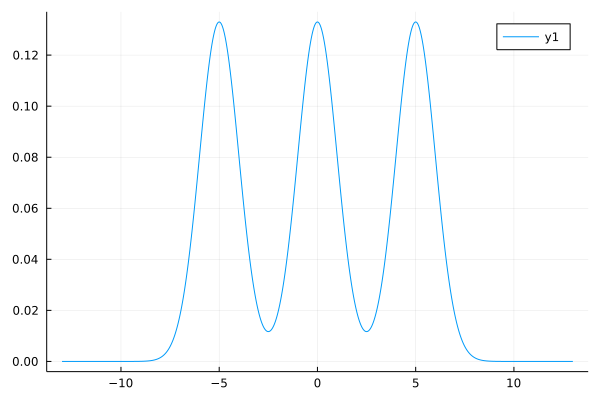

In [3]:
wmax = 13
omegas = LinRange(-wmax, wmax, 1000)
plot(omegas, aomega.(omegas))

In [4]:
c = quadgk(x -> aomega(x), -wmax, wmax)[1]
println("normalize=", quadgk(x -> aomega(x), -wmax, wmax)[1])


normalize=0.9999999999999997


# particle

$$
T^{(n)}_p = (-1)^{n+1} \frac{d^n G(\tau)}{d\tau^n} \mid_{\tau=0^+}
$$

$$
T^{(n)}_h = (-1)^{n} \frac{d^n G(\tau)}{d\tau^n} \mid_{\tau=0^+}
$$

$$
S_n = T[0]^{-1/2} T[n] T[0]^{-1/2}
$$

In [5]:
nmom = 20
Tp = Float64[]
for mom in 0:(nmom-1)
    push!(Tp, quadgk(x -> (x^mom) * aomega(x), 0, wmax)[1])
end
Tp

20-element Vector{Float64}:
      0.4999999999999998
      1.7996474624415786
      8.833333333333297
     46.93262819373837
    259.8333333333272
   1484.3971794182223
   8715.833333332275
  52473.04974314345
 323344.16666648403
      2.0364177312761673e6
      1.309193083330184e7
      8.582304397903864e7
      5.731239058279008e8
      3.8954873943487306e9
      2.6928017108229156e10
      1.8917679644289713e11
      1.3498038098089817e12
      9.77584610182314e12
      7.182588839821647e13
      5.350946429183264e14

In [6]:
function reconst(T)
    nmom = length(T)
    S = (1/sqrt(T[1])) * T * (1/sqrt(T[1]))
    println(S)

    As = Dict{Int,ComplexF64}()
    Bs = Dict{Int,ComplexF64}()
    Cs = Dict{Tuple{Int,Int},ComplexF64}()

    # Initial values
    As[0] = S[2]
    Bs[0] = 0.0
    Cs[0,0] = 1.0

    function get_S(i)
        i <= nmom-1 ? S[i+1] : 0.0
    end
    
    function get_Cs(n, j)::ComplexF64
        if j < 0 || j > n || n < 0
            return 0.0
        end
        return Cs[(n, j)]
    end

    for n in 0:nmom
        #println("n = $n")
        # Update B[n+1]
        bfirst = sum(conj(Cs[n,l]) * get_S(j+l+1) * get_Cs(n, j-1) for j in 0:(n+1), l in 0:n)
        Bs[n+1] = sqrt(bfirst  - As[n]^2  - conj(Bs[n]^2))

        # C(n+1, j) for j = 0, ..., n+1 (otherwise 0)
        for j in 0:(n+1)
            Cs[(n+1, j)] = (get_Cs(n, j-1) - get_Cs(n, j) * As[n] - get_Cs(n-1, j) * conj(Bs[n])) / Bs[n+1]
        end

        # Update A[n+1]
        As[n+1] = sum(conj(get_Cs(n+1, l) * get_S(j+l+1) * get_Cs(n+1, j)) for j in 0:(n+1), l in 0:(n+1))

        if length(As) >= (nmom + 1) ÷ 2
            break
        end
    end
    return  As, Bs
end

As, Bs = reconst(Tp)


[1.0, 3.599294924883159, 17.6666666666666, 93.86525638747676, 519.6666666666546, 2968.7943588364456, 17431.666666664558, 104946.09948628694, 646688.3333329684, 4.072835462552336e6, 2.6183861666603692e7, 1.7164608795807737e8, 1.146247811655802e9, 7.790974788697465e9, 5.385603421645834e10, 3.7835359288579443e11, 2.6996076196179644e12, 1.955169220364629e13, 1.43651776796433e14, 1.0701892858366532e15]


(Dict{Int64, ComplexF64}(0 => 3.599294924883159 + 0.0im, 4 => 4.480810249317074 + 0.0im, 5 => 4.864744902792154 + 0.0im, 6 => 4.717944839037955 + 0.0im, 2 => 4.516038810694084 + 0.0im, 7 => 5.143641754984856 + 0.0im, 9 => 5.400282144546509 + 0.0im, 8 => 5.368327662348747 + 0.0im, 3 => 3.813969859494591 + 0.0im, 1 => 2.826716548081798 + 0.0im…), Dict{Int64, ComplexF64}(0 => 0.0 + 0.0im, 4 => 2.3359299862752323 + 0.0im, 5 => 2.1503817431728383 + 0.0im, 6 => 2.425369432674304 + 0.0im, 2 => 1.660444105418668 + 0.0im, 7 => 2.558258663940889 + 0.0im, 9 => 2.7062503223151566 + 0.0im, 8 => 2.5437730692767153 + 0.0im, 3 => 1.9539312258447914 + 0.0im, 1 => 2.170654903566418 + 0.0im…))

In [7]:
nc = length(As)
htri = zeros(ComplexF64, nc, nc)
for i in 1:nc
    htri[i, i] = As[i-1]
end
for i in 1:(nc-1)
    htri[i, i+1] = Bs[i]
    htri[i+1, i] = conj(Bs[i])
end

htri

10×10 Matrix{ComplexF64}:
 3.59929+0.0im  2.17065+0.0im      0.0+0.0im  …      0.0+0.0im      0.0+0.0im
 2.17065-0.0im  2.82672+0.0im  1.66044+0.0im         0.0+0.0im      0.0+0.0im
     0.0+0.0im  1.66044-0.0im  4.51604+0.0im         0.0+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im  1.95393-0.0im         0.0+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im      0.0+0.0im         0.0+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im      0.0+0.0im  …      0.0+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im      0.0+0.0im         0.0+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im      0.0+0.0im     2.54377+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im      0.0+0.0im     5.36833+0.0im  2.70625+0.0im
     0.0+0.0im      0.0+0.0im      0.0+0.0im     2.70625-0.0im  5.40028+0.0im

In [8]:
e = eigen(Hermitian(htri))

Eigen{ComplexF64, Float64, Matrix{ComplexF64}, Vector{Float64}}
values:
10-element Vector{Float64}:
 0.10417295989521268
 0.5275893171374101
 1.2453687958072237
 2.5078330375974
 3.9672836940183784
 5.069819715263219
 6.127277002118245
 7.19829540110092
 8.336127402458963
 9.648004370783934
vectors:
10×10 Matrix{ComplexF64}:
 -0.264482-0.0im  -0.364353-0.0im  …   0.0349183-0.0im   0.0028342-0.0im
  0.425861+0.0im   0.515598+0.0im      0.0761991-0.0im  0.00789775-0.0im
 -0.352512-0.0im  -0.237612-0.0im       0.207184-0.0im   0.0287397-0.0im
  0.434056+0.0im  0.0468696+0.0im       0.340306-0.0im   0.0687729-0.0im
 -0.394479-0.0im   0.132815-0.0im       0.485501-0.0im    0.147722-0.0im
  0.331368+0.0im  -0.295078-0.0im  …    0.500762+0.0im    0.280257-0.0im
 -0.300664-0.0im   0.409915+0.0im       0.286275-0.0im    0.421743-0.0im
  0.228087+0.0im   -0.39168-0.0im     -0.0698666-0.0im    0.547049-0.0im
 -0.149487-0.0im   0.298511+0.0im      -0.375589-0.0im    0.544537+0.0im
 0.0763859+0.0im

In [9]:
weight = real.(conj.(e.vectors[1, :]) .* e.vectors[1, :])

10-element Vector{Float64}:
 0.06995082738112408
 0.13275331509228208
 0.1071222195728195
 0.04964658124961701
 0.18138088536245528
 0.2831128529837965
 0.14884029530326845
 0.025965705405192902
 0.001219284933702284
 8.03271574211536e-6

In [10]:
sum(weight)

1.0000000000000002

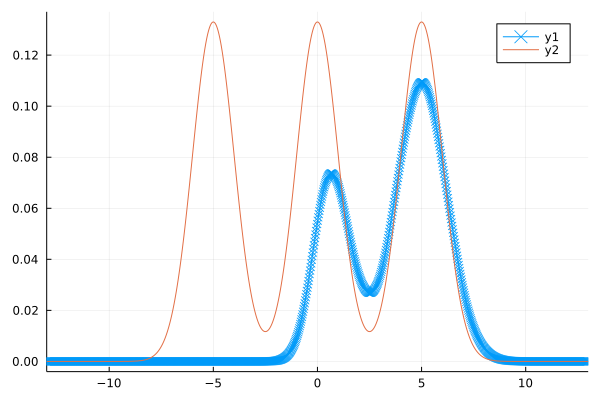

In [11]:
δ = 0.7
#p = 0.25
gaussian(x, μ) = exp(-0.5 * ((x-μ)/δ)^2)/(sqrt(2π) * δ)

cp = quadgk(x -> aomega(x), 0, wmax)[1]
aomega_reconst = zeros(Float64, length(omegas))
for ie in eachindex(e.values)
    aomega_reconst .+= cp * gaussian.(omegas, e.values[ie]) * weight[ie]
end

p = plot(xlim=(-wmax, wmax))
plot!(p, omegas, (aomega_reconst), xlim=(-wmax, wmax), marker=:x)
plot!(p, omegas, aomega.(omegas))

# hole

In [12]:

Th = Float64[]
for mom in 0:(nmom-1)
    push!(Th, quadgk(x -> (x^mom) * aomega(x), -wmax, 0)[1])
end
Th

20-element Vector{Float64}:
      0.4999999999999998
     -1.7996474624415788
      8.833333333333298
    -46.93262819373837
    259.8333333333272
  -1484.3971794182223
   8715.833333332273
 -52473.049743143456
 323344.16666648403
     -2.0364177312761673e6
      1.309193083330184e7
     -8.582304397903866e7
      5.731239058279008e8
     -3.8954873943487306e9
      2.692801710822916e10
     -1.8917679644289713e11
      1.3498038098089814e12
     -9.775846101823139e12
      7.182588839821645e13
     -5.350946429183263e14

In [13]:
Ash, Bsh = reconst(Th)

[1.0, -3.599294924883159, 17.666666666666604, -93.86525638747676, 519.6666666666546, -2968.7943588364456, 17431.666666664554, -104946.09948628697, 646688.3333329684, -4.072835462552336e6, 2.6183861666603692e7, -1.7164608795807737e8, 1.146247811655802e9, -7.790974788697465e9, 5.385603421645834e10, -3.7835359288579443e11, 2.6996076196179644e12, -1.955169220364629e13, 1.4365177679643297e14, -1.070189285836653e15]


(Dict{Int64, ComplexF64}(0 => -3.599294924883159 + 0.0im, 4 => -4.480810249438946 + 0.0im, 5 => -4.864744905295083 + 0.0im, 6 => -4.7179448620881885 + 0.0im, 2 => -4.516038810694113 + 0.0im, 7 => -5.143641955219209 + 0.0im, 9 => -5.400242447853088 + 0.0im, 8 => -5.36832769215107 + 0.0im, 3 => -3.8139698594977745 + 0.0im, 1 => -2.8267165480817944 + 0.0im…), Dict{Int64, ComplexF64}(0 => 0.0 + 0.0im, 4 => 2.335929986265956 + 0.0im, 5 => 2.1503817428883636 + 0.0im, 6 => 2.42536942893819 + 0.0im, 2 => 1.660444105418673 + 0.0im, 7 => 2.558258632072538 + 0.0im, 9 => 2.706252623410078 + 0.0im, 8 => 2.5437727725948793 + 0.0im, 3 => 1.9539312258445474 + 0.0im, 1 => 2.170654903566419 + 0.0im…))

In [14]:
nch = length(Ash)
htrih = zeros(ComplexF64, nc, nc)
for i in 1:nch
    htrih[i, i] = Ash[i-1]
end
for i in 1:(nch-1)
    htrih[i, i+1] = Bsh[i]
    htrih[i+1, i] = conj(Bsh[i])
end

htrih

10×10 Matrix{ComplexF64}:
 -3.59929+0.0im   2.17065+0.0im  …       0.0+0.0im       0.0+0.0im
  2.17065-0.0im  -2.82672+0.0im          0.0+0.0im       0.0+0.0im
      0.0+0.0im   1.66044-0.0im          0.0+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im          0.0+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im          0.0+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im  …       0.0+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im          0.0+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im      2.54377+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im     -5.36833+0.0im   2.70625+0.0im
      0.0+0.0im       0.0+0.0im      2.70625-0.0im  -5.40024+0.0im

In [15]:
eh = eigen(Hermitian(htrih))

Eigen{ComplexF64, Float64, Matrix{ComplexF64}, Vector{Float64}}
values:
10-element Vector{Float64}:
 -9.648000343089343
 -8.3361232348772
 -7.198291058780745
 -6.127272451400469
 -5.069814906852262
 -3.967278467638888
 -2.507824921582144
 -1.2453660401389661
 -0.5275881162390847
 -0.10417271460330034
vectors:
10×10 Matrix{ComplexF64}:
 -0.00283423-0.0im  -0.0349185-0.0im  …   -0.364353-0.0im  0.264482-0.0im
  0.00789781+0.0im   0.0761996+0.0im      -0.515598-0.0im  0.425861-0.0im
    -0.02874-0.0im   -0.207185-0.0im      -0.237612-0.0im  0.352511-0.0im
   0.0687734+0.0im    0.340307+0.0im     -0.0468709-0.0im  0.434056-0.0im
   -0.147723-0.0im   -0.485502-0.0im       0.132813-0.0im  0.394479+0.0im
    0.280258+0.0im    0.500761+0.0im  …    0.295076-0.0im  0.331368-0.0im
   -0.421744-0.0im   -0.286272-0.0im       0.409914+0.0im  0.300665-0.0im
    0.547049+0.0im  -0.0698701-0.0im        0.39168-0.0im  0.228087-0.0im
   -0.544536-0.0im    0.375591+0.0im       0.298512-0.0im  0.149487-0.0

In [16]:
weighth = real.(conj.(eh.vectors[1, :]) .* eh.vectors[1, :])

10-element Vector{Float64}:
 8.032866771224738e-6
 0.0012193020474607326
 0.025965957799595592
 0.1488410909428202
 0.2831130274375678
 0.18138001231375347
 0.04964645974940657
 0.10712234219725837
 0.1327531087898533
 0.06995066585551271

In [17]:
sum(weighth)

1.0

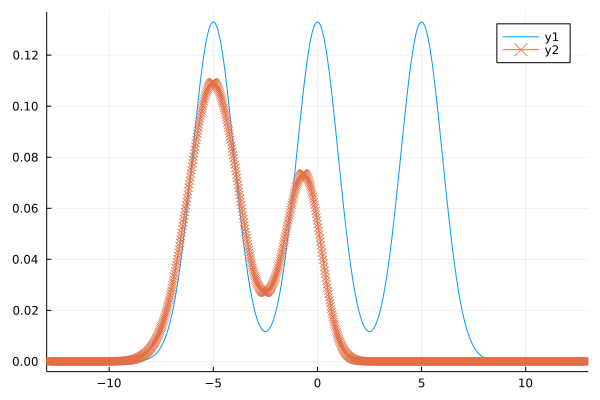

In [18]:
#hole
δh = 0.7
gaussianh(x, μh) = exp(-0.5 * ((x-μh)/δh)^2)/(sqrt(2π) * δh)

#hole
ch = quadgk(x -> aomega(x), -wmax, 0)[1]
aomega_reconsth = zeros(Float64, length(omegas))
for ieh in eachindex(eh.values)
    aomega_reconsth .+= ch * gaussianh.(omegas, eh.values[ieh]) * weighth[ieh]
end


p = plot(xlim=(-wmax, wmax))
plot!(p, omegas, aomega.(omegas))
plot!(p, omegas, (aomega_reconsth), xlim=(-wmax, wmax), marker=:x)

# whole picture

In [19]:
aomega_reconst_all = (aomega_reconst + aomega_reconsth)
#println(aomega_reconst_all)
p = plot(xlim=(-wmax, wmax))
plot!(p, omegas, aomega.(omegas))
plot!(p, omegas, (aomega_reconst_all), xlim=(-wmax, wmax), marker=:x)
#plot!(p, omegas, (aomega_reconsth),  xlim=(-wmax, wmax), maker=:x)


In [ ]:
delta = 1

In [ ]:
savefig("nmom=$(delta)")